# Word Clouds

Let's generate them.

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

from sklearn import naive_bayes, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
RANDOM_STATE = 42

In [3]:
pd.set_option('display.max_columns', None)

# Load the data

In [4]:
lemmas = pd.read_csv('../data/lemmas.csv')

In [5]:
annotations = pd.read_csv('../data/poem_value_save.csv')

In [6]:
annotations

,book_poem_id,poem_id,book_id,id_topic,value,name
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,1,-1,Dětství/mateřství/rodičovství
1,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,2,-1,Domov
2,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,3,-1,Exotika/cestovatelství
3,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,4,-1,Chudoba/útisk
4,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,9,-1,Náboženství/víra
...,...,...,...,...,...,...
27154,1675_0001-0009-0000-0015-0002,0001-0009-0000-0015-0002,1675,26,-1,Město
27155,1675_0001-0009-0000-0015-0002,0001-0009-0000-0015-0002,1675,27,-1,Venkov
27156,1675_0001-0009-0000-0015-0002,0001-0009-0000-0015-0002,1675,28,-1,Národ/vlast
27157,1675_0001-0009-0000-0015-0002,0001-0009-0000-0015-0002,1675,29,-1,Historie


# Filter out assignments with values -1 and 0

In [7]:
annotations_1 = annotations[annotations.value == 1].reset_index(drop=True)
annotations_1

,book_poem_id,poem_id,book_id,id_topic,value,name
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,13,1,Práce
1,2_0001-0000-0000-0008-0000,0001-0000-0000-0008-0000,2,9,1,Náboženství/víra
2,3_0001-0003-0000-0012-0000,0001-0003-0000-0012-0000,3,9,1,Náboženství/víra
3,7_0001-0000-0000-0065-0000,0001-0000-0000-0065-0000,7,20,1,"Umění/literatura, poezie/tvorba"
4,8_0001-0000-0000-0004-0000,0001-0000-0000-0004-0000,8,30,1,Sebereflexe/vnitřní život
...,...,...,...,...,...,...
917,1675_0001-0005-0000-0028-0000,0001-0005-0000-0028-0000,1675,14,1,Příroda
918,1675_0001-0005-0000-0042-0000,0001-0005-0000-0042-0000,1675,30,1,Sebereflexe/vnitřní život
919,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,12,1,Politika/společnost
920,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,26,1,Město


# Join annotations with lemmas

In [8]:
annotations_lemmas = pd.merge(annotations_1, lemmas, on='book_poem_id', how='left')

In [9]:
annotations_lemmas

,book_poem_id,poem_id,book_id,id_topic,value,name,lemmas
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,13,1,Práce,"[('chuť', 'N'), ('k', 'R'), ('práce', 'N'), ('..."
1,2_0001-0000-0000-0008-0000,0001-0000-0000-0008-0000,2,9,1,Náboženství/víra,"[('truchlit', 'V'), ('když', 'J'), ('rána', 'N..."
2,3_0001-0003-0000-0012-0000,0001-0003-0000-0012-0000,3,9,1,Náboženství/víra,"[('srdce', 'N'), ('Páně', 'A'), ('velechrám', ..."
3,7_0001-0000-0000-0065-0000,0001-0000-0000-0065-0000,7,20,1,"Umění/literatura, poezie/tvorba","[('náš', 'P'), ('lid', 'N'), ('ty', 'P'), ('ch..."
4,8_0001-0000-0000-0004-0000,0001-0000-0000-0004-0000,8,30,1,Sebereflexe/vnitřní život,"[('mít', 'V'), ('plout', 'V'), ('loď', 'N'), (..."
...,...,...,...,...,...,...,...
917,1675_0001-0005-0000-0028-0000,0001-0005-0000-0028-0000,1675,14,1,Příroda,"[('do', 'R'), ('duše', 'N'), ('rozjásaný', 'A'..."
918,1675_0001-0005-0000-0042-0000,0001-0005-0000-0042-0000,1675,30,1,Sebereflexe/vnitřní život,"[('ó', 'I'), ('smutný', 'A'), ('srdce', 'N'), ..."
919,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,12,1,Politika/společnost,"[('jít', 'V'), ('mimo', 'R'), ('nalíčený', 'A'..."
920,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,26,1,Město,"[('jít', 'V'), ('mimo', 'R'), ('nalíčený', 'A'..."


# Filter the data

- Filter out all POS but Nouns (N), Adjectives (A) and Verbs (V)

- Filter out frequent (stop)words that does not carry any extra semantic information

In [10]:
stopwords = ['mít', 'jít', 'být', 'dát', 'moci']

In [11]:
%%time

lemmas_filtered_column = []

# extract lemmas with N, A or V POS tag
for index, poem in annotations_lemmas.iterrows():
    if index % 1000 == 0:
        print(index, end=' ')
    
    lemmas_filtered_poem = []
    lemmas_poem = literal_eval(poem['lemmas'])
    for lemma_pos in lemmas_poem:
        lemma, pos = lemma_pos
        if pos in ['N', 'A', 'V'] and lemma not in stopwords:
            lemmas_filtered_poem.append(lemma)
    lemmas_filtered_column.append(lemmas_filtered_poem)

0 CPU times: user 932 ms, sys: 13.4 ms, total: 945 ms
Wall time: 949 ms


In [12]:
annotations_lemmas['lemmas_filtered'] = lemmas_filtered_column

In [13]:
annotations_lemmas

,book_poem_id,poem_id,book_id,id_topic,value,name,lemmas,lemmas_filtered
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,13,1,Práce,"[('chuť', 'N'), ('k', 'R'), ('práce', 'N'), ('...","[chuť, práce, milý, dítě, bůh, práce, síla, ďá..."
1,2_0001-0000-0000-0008-0000,0001-0000-0000-0008-0000,2,9,1,Náboženství/víra,"[('truchlit', 'V'), ('když', 'J'), ('rána', 'N...","[truchlit, rána, bolný, lidský, zloba, usoudit..."
2,3_0001-0003-0000-0012-0000,0001-0003-0000-0012-0000,3,9,1,Náboženství/víra,"[('srdce', 'N'), ('Páně', 'A'), ('velechrám', ...","[srdce, Páně, velechrám, svatý, skvít, záře, k..."
3,7_0001-0000-0000-0065-0000,0001-0000-0000-0065-0000,7,20,1,"Umění/literatura, poezie/tvorba","[('náš', 'P'), ('lid', 'N'), ('ty', 'P'), ('ch...","[lid, chránit, stánek, chudý, slavíček, smutný..."
4,8_0001-0000-0000-0004-0000,0001-0000-0000-0004-0000,8,30,1,Sebereflexe/vnitřní život,"[('mít', 'V'), ('plout', 'V'), ('loď', 'N'), (...","[plout, loď, daleký, vodní, pláň, modrý, dálka..."
...,...,...,...,...,...,...,...,...
917,1675_0001-0005-0000-0028-0000,0001-0005-0000-0028-0000,1675,14,1,Příroda,"[('do', 'R'), ('duše', 'N'), ('rozjásaný', 'A'...","[duše, rozjásaný, slavný, zachytit, zář, korun..."
918,1675_0001-0005-0000-0042-0000,0001-0005-0000-0042-0000,1675,30,1,Sebereflexe/vnitřní život,"[('ó', 'I'), ('smutný', 'A'), ('srdce', 'N'), ...","[smutný, srdce, zatoulat, bledý, soumrak, vůně..."
919,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,12,1,Politika/společnost,"[('jít', 'V'), ('mimo', 'R'), ('nalíčený', 'A'...","[nalíčený, žena, zrak, hořet, tmít, obočí, šíj..."
920,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,26,1,Město,"[('jít', 'V'), ('mimo', 'R'), ('nalíčený', 'A'...","[nalíčený, žena, zrak, hořet, tmít, obočí, šíj..."


In [14]:
annotations_lemmas = annotations_lemmas.drop(['name'], axis=1)

# Compute topic coherence of annotated topics

code for c-TF-IDF from: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

In [15]:
# Create the library
min_frequency = 20
dictionary = Dictionary(annotations_lemmas['lemmas_filtered'])
# Filter out words
dictionary.filter_extremes(no_below=min_frequency)

In [16]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):    
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    
    return tf_idf, count


def extract_top_n_words_per_cluster(tf_idf, count, docs_per_cluster, groupby, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_cluster[groupby])
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words


def extract_topic_sizes(df, groupby):
    topic_sizes = (df.groupby([groupby])
                     .preprocessed_text
                     .count()
                     .reset_index()
                     .rename({"preprocessed_text": "size"}, axis='columns')
                     .sort_values("size", ascending=False))
    return topic_sizes

In [17]:
from collections import Counter

# create word frequency count
word_counts = Counter(word for row in annotations_lemmas['lemmas_filtered'] for word in row)

# filter lists based on word frequency count
annotations_lemmas['lemmas_filtered_a'] = annotations_lemmas['lemmas_filtered'].apply(lambda x: [word for word in x if word_counts[word] >= 20])

In [18]:
annotations_lemmas['preprocessed_text'] = annotations_lemmas['lemmas_filtered_a'].apply(lambda x: ' '.join(x))

In [19]:
# merge documents in cluster into one document
docs_per_cluster = annotations_lemmas.groupby(['id_topic'], as_index = False).agg({'preprocessed_text': ' '.join})

In [20]:
docs_per_cluster

,id_topic,preprocessed_text
0,1,děcko hoch pustý ticho noc smrt stát sklonit k...
1,2,sedět hučet sníh padat vzpomínat cos šeptat hl...
2,3,země dávný hlubina žena slza smutek vracet pís...
3,4,oř oř mladý hoch stráň kráčet divný myšlénka h...
4,9,rána lidský zloba ruka pán jmout rána hlas vol...
5,12,rok studený rok horký stát moudrost osud čin v...
6,13,práce milý dítě bůh práce síla padat práce prá...
7,14,klín noc mladý den celý spánek vstát spící zem...
8,15,černý pták rok držet tvář bít hruď zrak tělo r...
9,16,hvězda hořet cítit život naděje kalný voda hoř...


In [21]:
tf_idf, count = c_tf_idf(docs_per_cluster.preprocessed_text.values, m=len(annotations_lemmas))

In [29]:
top_n_words = extract_top_n_words_per_cluster(tf_idf, count, docs_per_cluster, 'id_topic', n=10)
top_n_words

{1: [('matka', 0.04021608573694227),
  ('táta', 0.033631568831176135),
  ('dítě', 0.023842960227656064),
  ('máma', 0.02307808365746232),
  ('syn', 0.02050190608252387),
  ('děcko', 0.02013240521812311),
  ('zpívat', 0.019700126221114174),
  ('říci', 0.017628083676700105),
  ('čelo', 0.01711410688960598),
  ('boží', 0.017009846147469754)],
 2: [('domov', 0.027540626813980226),
  ('přítel', 0.026735600405658085),
  ('zahrada', 0.024672258794281966),
  ('okno', 0.024266197057341662),
  ('sníh', 0.023998739592966722),
  ('chata', 0.023033079610779685),
  ('vidět', 0.022568609516632362),
  ('nízký', 0.0225127575581179),
  ('střecha', 0.0225127575581179),
  ('najít', 0.01978226039319971)],
 3: [('hlubina', 0.0890782567577381),
  ('písek', 0.0881098440872867),
  ('celý', 0.053750622810089944),
  ('moře', 0.05076199010101059),
  ('touha', 0.04953737427040881),
  ('uzřít', 0.04669163933127371),
  ('rovný', 0.04669163933127371),
  ('ruch', 0.04611731815059602),
  ('pohár', 0.04556853095836351),

In [23]:
topic_sizes = extract_topic_sizes(annotations_lemmas, 'id_topic')
topic_sizes

,id_topic,size
18,25,171
23,30,111
4,9,85
7,14,85
10,17,77
5,12,64
13,20,64
21,28,51
9,16,37
22,29,32


In [24]:
def word_cloud(top_n_words, topic):
    word_dict = {word: prob for word, prob in top_n_words[topic]}

    wc = WordCloud(background_color='white', width=800, height=400)
    wc.generate_from_frequencies(word_dict)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [25]:
df_topics = pd.read_csv('../data/list_of_topics.csv')
df_topics

,id_topic,name
0,1,Dětství/mateřství/rodičovství
1,2,Domov
2,3,Exotika/cestovatelství
3,4,Chudoba/útisk
4,9,Náboženství/víra
5,11,Pokrok/technika
6,12,Politika/společnost
7,13,Práce
8,14,Příroda
9,15,Revoluce/Osvobození


1 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.05

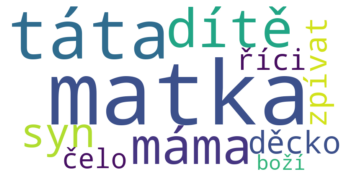

2 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.05

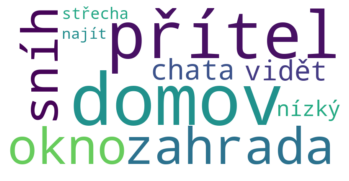

3 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.05

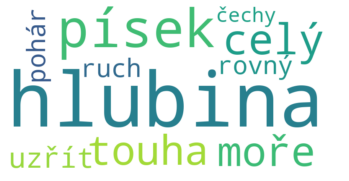

4 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.05

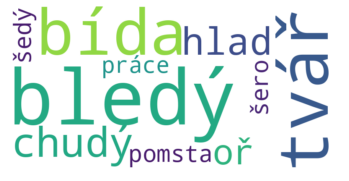

9 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.05

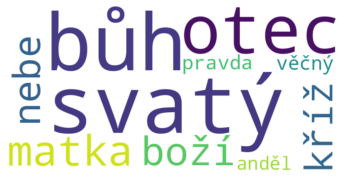

12 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

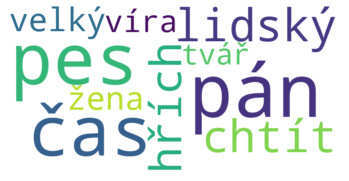

13 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

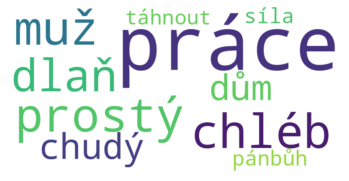

14 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

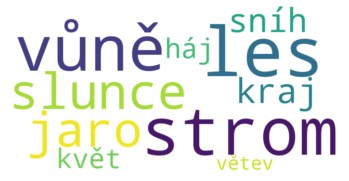

15 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

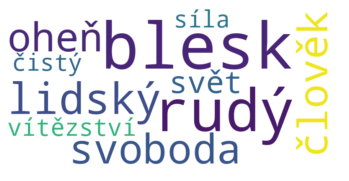

16 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

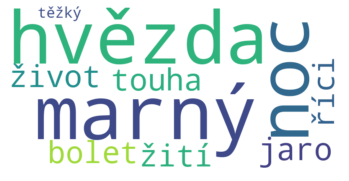

17 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

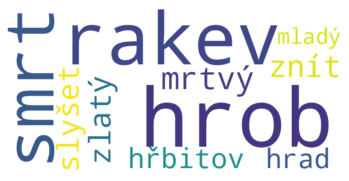

18 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

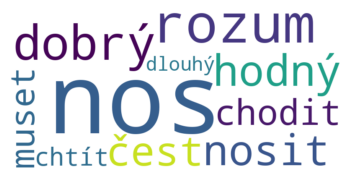

19 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

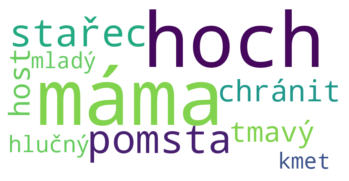

20 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

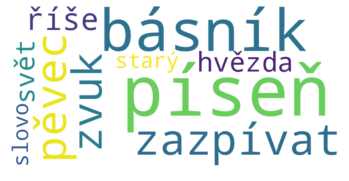

21 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

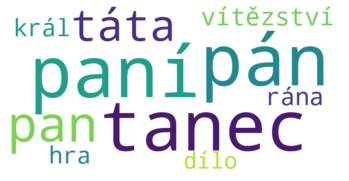

22 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

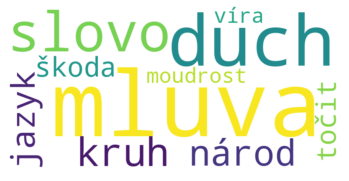

23 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

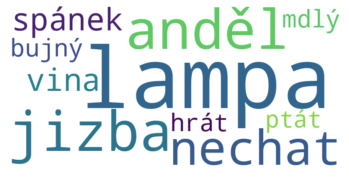

24 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

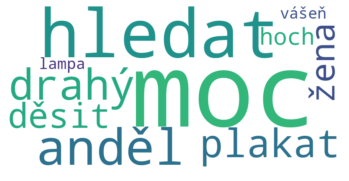

25 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

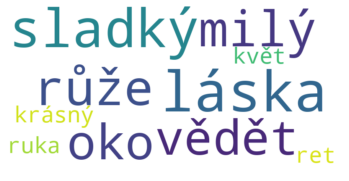

26 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

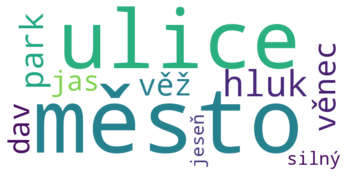

27 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

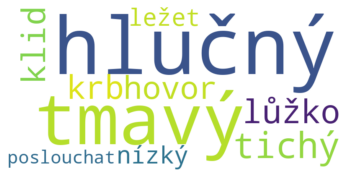

28 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

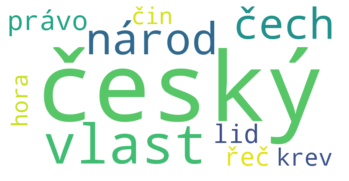

29 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

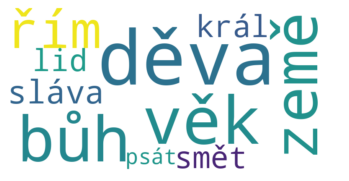

30 {1: [('matka', 0.04021608573694227), ('táta', 0.033631568831176135), ('dítě', 0.023842960227656064), ('máma', 0.02307808365746232), ('syn', 0.02050190608252387), ('děcko', 0.02013240521812311), ('zpívat', 0.019700126221114174), ('říci', 0.017628083676700105), ('čelo', 0.01711410688960598), ('boží', 0.017009846147469754)], 2: [('domov', 0.027540626813980226), ('přítel', 0.026735600405658085), ('zahrada', 0.024672258794281966), ('okno', 0.024266197057341662), ('sníh', 0.023998739592966722), ('chata', 0.023033079610779685), ('vidět', 0.022568609516632362), ('nízký', 0.0225127575581179), ('střecha', 0.0225127575581179), ('najít', 0.01978226039319971)], 3: [('hlubina', 0.0890782567577381), ('písek', 0.0881098440872867), ('celý', 0.053750622810089944), ('moře', 0.05076199010101059), ('touha', 0.04953737427040881), ('uzřít', 0.04669163933127371), ('rovný', 0.04669163933127371), ('ruch', 0.04611731815059602), ('pohár', 0.04556853095836351), ('čechy', 0.04504310361985985)], 4: [('bledý', 0.0

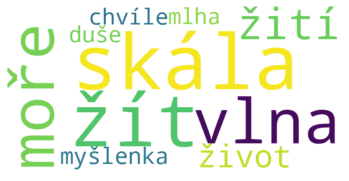

In [46]:
for i in [k for k in top_n_words]:
    print(df_topics[df_topics.id_topic == i].reset_index(drop=True).name[0])
    word_cloud(top_n_words, i)

In [ ]:
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(5):
    wc.generate(text=topics_df["Terms per Topic"][i])   
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])
plt.show()

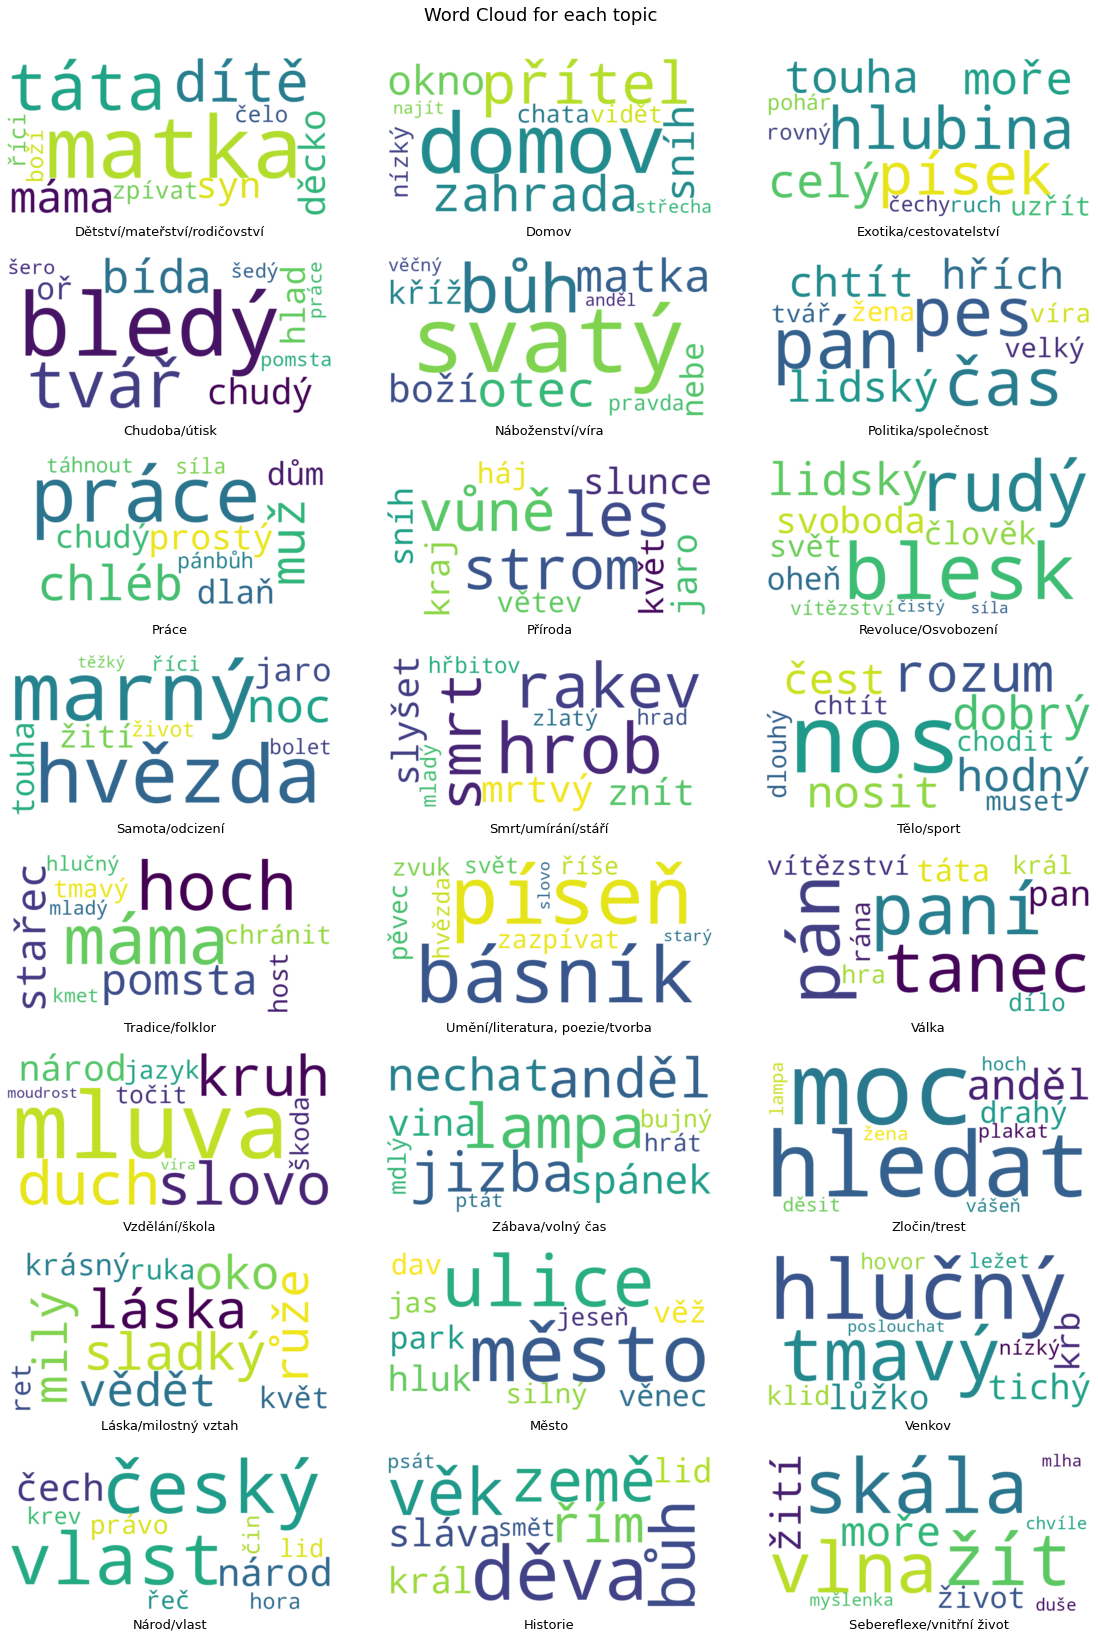

In [69]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(8, 3, figsize=(16, 24))
fig.tight_layout()

pos_x = 0
pos_y = 0

for x in [k for k in top_n_words]:
    
    word_dict = {word: prob for word, prob in top_n_words[x]}

    wc = WordCloud(background_color='white', width=800, height=400)
    wc.generate_from_frequencies(word_dict)
    #print(df_topics[df_topics.id_topic == x].reset_index(drop=True).name[0])
    
    ax[pos_x, pos_y].set_xlabel(df_topics[df_topics.id_topic == x].reset_index(drop=True).name[0])

    ax[pos_x, pos_y].imshow(wc, interpolation='bilinear')

    ax[pos_x, pos_y].spines[:].set_visible(False)
    ax[pos_x, pos_y].xaxis.set_major_locator(ticker.NullLocator())
    ax[pos_x, pos_y].yaxis.set_major_locator(ticker.NullLocator()) 

     
    pos_y += 1
    
    if pos_y == 3:
        pos_x += 1 
        pos_y = 0       

st = fig.suptitle('Word Cloud for each topic', fontsize=18)
# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.92)

plt.savefig('../img/all_word_clouds.png', dpi=400, bbox_inches='tight', pad_inches=0)

plt.show()

In [70]:
topics = []

for i in top_n_words:
    words_topic = []
    for word in top_n_words[i]:
        words_topic.append(word[0])
    topics.append(words_topic)

In [71]:
topics[0]

['matka',
 'táta',
 'dítě',
 'máma',
 'syn',
 'děcko',
 'zpívat',
 'říci',
 'čelo',
 'boží']

In [72]:
cm = CoherenceModel(topics=topics, topn=10, dictionary=dictionary, texts=annotations_lemmas['lemmas_filtered_a'], coherence='c_v')
coherence = cm.get_coherence()
coherence
# cim vyssi, tim lepsi

0.43905185837557864

In [73]:
from utils import topic_diversity

topic_diversity(topics, 10)

0.8416666666666667